# Log Analysis

In [1]:
import json
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
STYLE_TRAIN, COLOR_TRAIN = "s-", "#19c"
STYLE_EVAL, COLOR_EVAL = "^-", "#f91"

## Data Loading

In [3]:
logs_dir = Path("../logs")
log_dir = logs_dir / (
    sorted(e.name for e in logs_dir.iterdir())[-1]
)

print(log_dir.as_posix())
assert log_dir.exists()

../logs/20241012-132704


In [4]:
with (log_dir / "config.json").open(encoding="utf-8") as json_file:
    config = json.load(json_file)

In [5]:
df_statistics = pd.read_csv(
    log_dir/"statistics.csv",
    index_col=0,
)
df_statistics.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10 entries, 0 to 9
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   epoch               10 non-null     int64  
 1   train_time_seconds  10 non-null     float64
 2   eval_time_seconds   10 non-null     float64
 3   epoch_time_seconds  10 non-null     float64
 4   train_avg_loss      10 non-null     float64
 5   eval_avg_loss       5 non-null      float64
 6   eval_accuracy       5 non-null      float64
dtypes: float64(6), int64(1)
memory usage: 640.0 bytes


In [6]:
with (log_dir / "confusion_matrices.json").open(encoding="utf-8") as json_file:
    confusion_matrices = json.load(json_file)

len(confusion_matrices)

5

## Training Config

In [7]:
for key, value in config.items():
    print(f"######## {key} ########")
    print(value)

######## options ########
{'epochs': 10, 'lr': 0.1, 'eval_period': 2, 'device_name': 'cuda:0', 'save': True}
######## criterion ########
CrossEntropyLoss()
######## optimizer ########
SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.1
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)


## Training Time

In [8]:
train_times_in_seconds = df_statistics["train_time_seconds"]
total_train_times_in_seconds = train_times_in_seconds.sum()
mean_train_times_in_seconds = train_times_in_seconds.mean()
std_train_times_in_seconds = train_times_in_seconds.std()

print("Total Epoch(s)  : %23d" % len(df_statistics))
print(
    "Sum(TrainTime)  = %4.0f hr %3.0f min %3.0f sec"
    % (
        total_train_times_in_seconds // 3600,
        total_train_times_in_seconds // 60,
        total_train_times_in_seconds % 60,
    )
)
print(
    "Mean(TrainTime) = %4.0f hr %3.0f min %3.0f sec"
    % (
        mean_train_times_in_seconds // 3600,
        mean_train_times_in_seconds // 60,
        mean_train_times_in_seconds % 60,
    )
)
print(
    "Std(TrainTime)  = %4.0f hr %3.0f min %3.0f sec"
    % (
        std_train_times_in_seconds // 3600,
        std_train_times_in_seconds // 60,
        std_train_times_in_seconds % 60,
    )
)

Total Epoch(s)  :                      10
Sum(TrainTime)  =    0 hr   3 min   3 sec
Mean(TrainTime) =    0 hr   0 min  18 sec
Std(TrainTime)  =    0 hr   0 min   2 sec


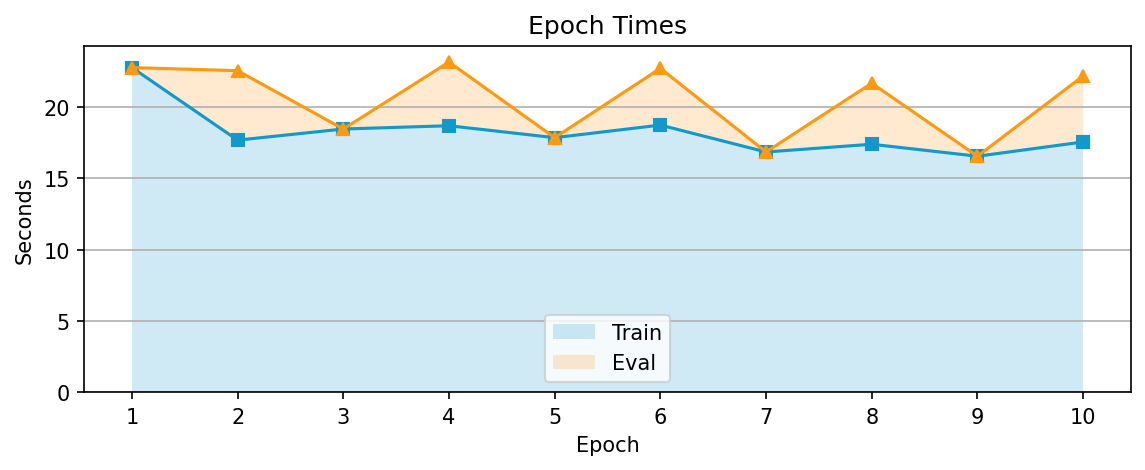

In [9]:
fig = plt.figure(figsize=(9, 3), dpi=150)
fig.set_facecolor("#fff")
ax = fig.add_subplot()

ax.stackplot(
    df_statistics["epoch"],
    train_times_in_seconds,
    df_statistics["eval_time_seconds"],
    labels=("Train", "Eval"),
    colors=(COLOR_TRAIN, COLOR_EVAL),
    alpha=0.2,
)
ax.plot(
    df_statistics["epoch"],
    train_times_in_seconds,
    STYLE_TRAIN,
    color=COLOR_TRAIN,
)
ax.plot(
    df_statistics["epoch"],
    train_times_in_seconds + df_statistics["eval_time_seconds"],
    STYLE_EVAL,
    color=COLOR_EVAL,
)
ax.set(
    title="Epoch Times",
    xlabel="Epoch",
    ylabel="Seconds",
    xticks=np.arange(
        df_statistics["epoch"].min(),
        df_statistics["epoch"].max() + 0.1,
        np.ceil(len(df_statistics) / 10),
    ),
)
ax.legend()
ax.grid(axis="y")

## Accuracy & Loss

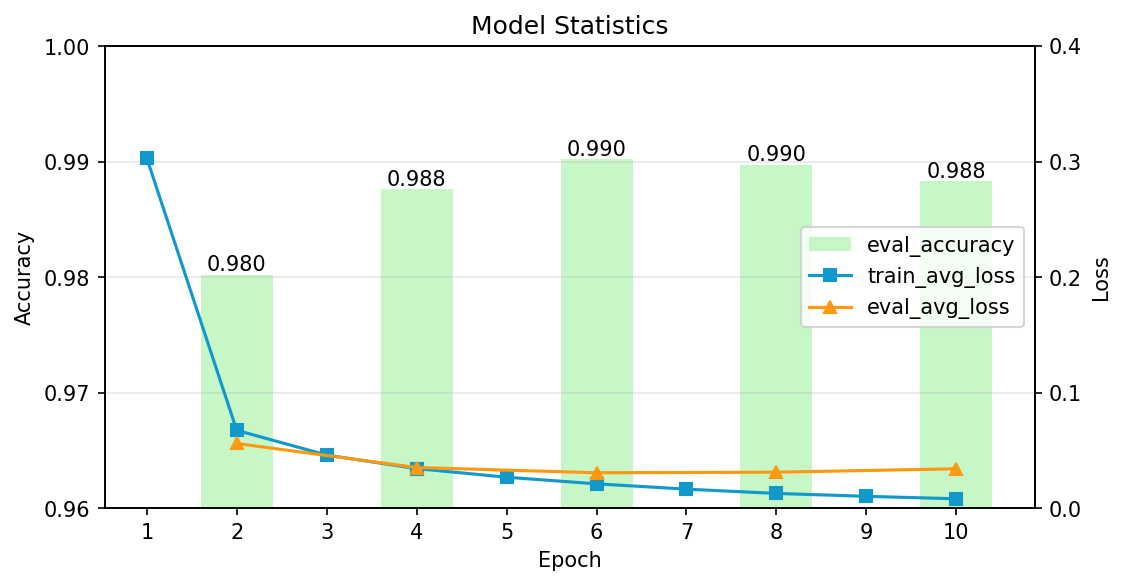

In [10]:
fig = plt.figure(figsize=(8, 4), dpi=150)
fig.set_facecolor("#fff")
ax_acc = fig.add_subplot()
ax_loss = ax_acc.twinx()

eval_mask = ~df_statistics["eval_accuracy"].isna()

ax_loss.legend(
    handles=[
        bars := ax_acc.bar(
            df_statistics["epoch"][eval_mask],
            df_statistics["eval_accuracy"][eval_mask],
            color="lightgreen",
            alpha=0.5,
            label="eval_accuracy",
        ),
        *ax_loss.plot(
            df_statistics["epoch"],
            df_statistics["train_avg_loss"],
            STYLE_TRAIN,
            color=COLOR_TRAIN,
            label="train_avg_loss",
        ),
        *ax_loss.plot(
            df_statistics["epoch"][eval_mask],
            df_statistics["eval_avg_loss"][eval_mask],
            STYLE_EVAL,
            color=COLOR_EVAL,
            label="eval_avg_loss",
        ),
    ],
    loc="center right",
)

for bar in bars:
    bar_height = bar.get_height()
    ax_acc.text(
        bar.get_x() + bar.get_width() / 2,
        bar_height,
        f"{bar_height:.3f}",
        ha='center',
        va='bottom'
    )

ax_acc.set(
    ylabel="Accuracy",
    title="Model Statistics",
    xlabel="Epoch",
    xticks=df_statistics["epoch"],
    ylim=(0.96, 1),
    yticks=np.arange(0.96, 1.001, 0.01),
)
ax_loss.set(
    ylabel="Loss",
    ylim=(0, 0.4),
    yticks=np.arange(0, 0.401, 0.1),
)
ax_acc.grid(axis="y", alpha=0.3)

## Confusion Matrix

array([[ 976,    0,    0,    1,    0,    1,    1,    0,    1,    0],
       [   1, 1126,    2,    1,    0,    1,    1,    1,    2,    0],
       [   1,    1, 1025,    0,    0,    0,    0,    2,    3,    0],
       [   1,    0,    1, 1003,    0,    3,    0,    0,    1,    1],
       [   0,    0,    1,    0,  974,    0,    0,    0,    0,    7],
       [   2,    0,    0,    4,    0,  885,    1,    0,    0,    0],
       [   6,    2,    0,    1,    1,    8,  938,    0,    2,    0],
       [   1,    1,   16,    0,    1,    0,    0,  997,    2,   10],
       [   3,    0,    1,    0,    0,    1,    0,    0,  967,    2],
       [   1,    1,    0,    0,    7,    2,    0,    3,    3,  992]])

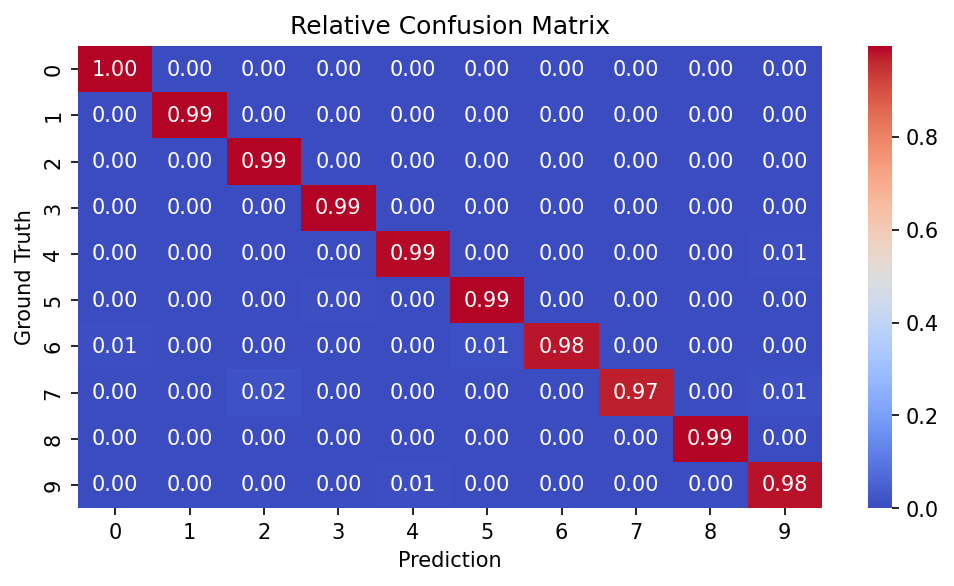

In [11]:
last_confusion_matrix = np.array(confusion_matrices[-1]["confusion_matrix"])
last_relative_confusion_matrix = (
    last_confusion_matrix / last_confusion_matrix.sum(axis=1)
)

fig = plt.figure(figsize=(8, 4), dpi=150)
fig.set_facecolor("#fff")
ax = fig.add_subplot()

sns.heatmap(
    last_relative_confusion_matrix,
    fmt=".2f",
    annot=True,
    cmap="coolwarm",
)
ax.set(
    title="Relative Confusion Matrix",
    xlabel="Prediction",
    ylabel="Ground Truth",
)

last_confusion_matrix